# Custom CNN Model for Musical Instrument Classification

This notebook demonstrates how to create and train a custom CNN model for musical instrument classification using our project's modular structure. Building a custom model from scratch provides:

1. A deeper understanding of CNN architecture design principles
2. Insights into how each component contributes to model performance
3. A solution specifically tailored to our musical instrument dataset
4. Experience in developing neural networks from first principles

## Approach Using Our Project Structure

We'll leverage our organized project structure to:

1. **Load configuration** - Use YAML-based configuration for consistent experiments
2. **Prepare data** - Use our data modules for preprocessing and loading
3. **Define model architecture** - Import our custom CNN model from the module
4. **Configure training** - Set up optimizers and schedulers through our utilities
5. **Train the model** - Use our training pipeline for efficient model training
6. **Evaluate performance** - Leverage our metrics and evaluation modules
7. **Visualize results** - Create insightful visualizations with our plotting module

Let's begin by setting up our environment with the necessary imports from our project structure.

In [ ]:
# Import pandas at the beginning with other imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm

# Add project root to path to ensure imports work correctly
project_root = str(Path().resolve().parent)
sys.path.append(project_root)
print(f"Project root added to path: {project_root}")

# Import our project modules
from scripts.colab_integration import setup_colab_environment, check_gpu
from src.data.preprocessing import get_preprocessing_transforms
from src.data.augmentation import AdvancedAugmentation
from src.data.dataloader import load_datasets
from src.models.custom_cnn import create_custom_cnn
from src.training.trainer import train_model, evaluate_model
from src.training.metrics import compute_metrics, get_confusion_matrix
from src.visualization.plotting import plot_training_history, plot_confusion_matrix, plot_sample_predictions
from src.models.model_utils import save_model, load_saved_model

# Check if we're running in Colab and set up the environment
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

if IN_COLAB:
    print("🚀 Running in Google Colab - setting up environment...")
    setup_colab_environment()  # This handles all the Colab-specific setup
else:
    print("💻 Running locally - using local environment")

# Set device for training (GPU if available, otherwise CPU)
device = check_gpu()  # Our utility function for GPU detection

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Project root added to path: C:\Users\Daniel\Desktop\Univeristy\ULB\Master\MA1\MA1-Q2\X-PROJ-H419\proj-h419-MIC-github
💻 Running locally - using local environment
Using device: cpu
No GPU detected, using CPU. Training will be slower.


## 1. Configuration Loading

Let's load our model configuration from the custom model YAML file using our new project structure.

In [3]:
# Load configuration from YAML file
config_path = os.path.join(project_root, "config", "custom_model_v1.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Display the configuration for verification
print("Configuration loaded from:", config_path)
print("\nModel configuration:")
print(f"- Architecture: {config['model']['architecture']}")
print(f"- Name: {config['model']['name']}")
print(f"- Input channels: {config['model']['input_channels']}")
print(f"- Num classes: {config['model']['num_classes']}")
print(f"- Dropout rate: {config['model']['dropout_rate']}")

print("\nTraining configuration:")
print(f"- Batch size: {config['training']['batch_size']}")
print(f"- Num epochs: {config['training']['num_epochs']}")
print(f"- Optimizer: {config['training']['optimizer']['name']}")
print(f"- Learning rate: {config['training']['optimizer']['learning_rate']}")

print("\nData configuration:")
print(f"- Image size: {config['data']['img_size']}x{config['data']['img_size']}")
print(f"- Data directory: {config['data']['data_dir']}")

Configuration loaded from: C:\Users\Daniel\Desktop\Univeristy\ULB\Master\MA1\MA1-Q2\X-PROJ-H419\proj-h419-MIC-github\config\custom_model_v1.yaml

Model configuration:
- Architecture: CustomMusicCNN
- Name: custom_cnn
- Input channels: 3
- Num classes: 30
- Dropout rate: 0.5

Training configuration:
- Batch size: 32
- Num epochs: 50
- Optimizer: adam
- Learning rate: 0.001

Data configuration:
- Image size: 224x224
- Data directory: data\raw\30_Musical_Instruments\


## 2. Data Preparation and Loading

We'll use our project's data utilities to preprocess and load the dataset.

In [4]:
# Configure data path based on environment
if IN_COLAB:
    data_dir = "data/raw/30_Musical_Instruments"
    if not os.path.exists(data_dir):
        print("Please upload the dataset to Google Drive or adjust the path")
else:
    # Use the path from config or default to the project's data directory
    data_dir = os.path.join(project_root, config['data']['data_dir'])
    
print(f"\nUsing data directory: {data_dir}")

# Get preprocessing transforms with the appropriate image size from config
img_size = config['data']['img_size']

# Check if we should use data augmentation
if 'augmentation' in config and config['augmentation'].get('augmentation_strength'):
    print(f"Using advanced augmentation with strength: {config['augmentation']['augmentation_strength']}")
    transforms = AdvancedAugmentation.get_advanced_transforms(
        img_size=img_size,
        augmentation_strength=config['augmentation']['augmentation_strength']
    )
else:
    print("Using standard preprocessing (no advanced augmentation)")
    transforms = get_preprocessing_transforms(img_size=img_size)

# Load datasets using our utility function
data = load_datasets(
    data_dir=data_dir,
    transforms=transforms,
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    pin_memory=config['data'].get('pin_memory', torch.cuda.is_available())
)

# Access the components
train_loader = data['dataloaders']['train']
valid_loader = data['dataloaders']['val']
test_loader = data['dataloaders']['test']

# Get class information
class_names = list(data['class_mappings']['idx_to_class'].values())
num_classes = data['num_classes']

print(f"\nDataset loaded successfully:")
print(f"- Number of classes: {num_classes}")
print(f"- Training samples: {len(data['datasets']['train'])}")
print(f"- Validation samples: {len(data['datasets']['val'])}")
print(f"- Test samples: {len(data['datasets']['test'])}")

# Display a few class names
print(f"\nSample classes: {class_names[:5]}...")


Using data directory: C:\Users\Daniel\Desktop\Univeristy\ULB\Master\MA1\MA1-Q2\X-PROJ-H419\proj-h419-MIC-github\data\raw\30_Musical_Instruments\
Using advanced augmentation with strength: medium

Dataset loaded successfully:
- Number of classes: 30
- Training samples: 4793
- Validation samples: 150
- Test samples: 150

Sample classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn']...


### Visualize Sample Images

Let's visualize a few images using our project's visualization utilities:

Original images from dataset:


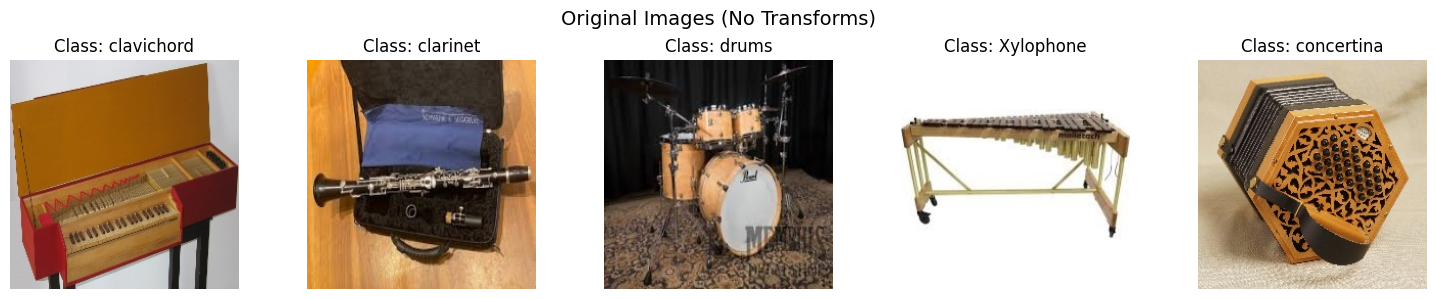

Transformed images (showing the RandomErasing effect):


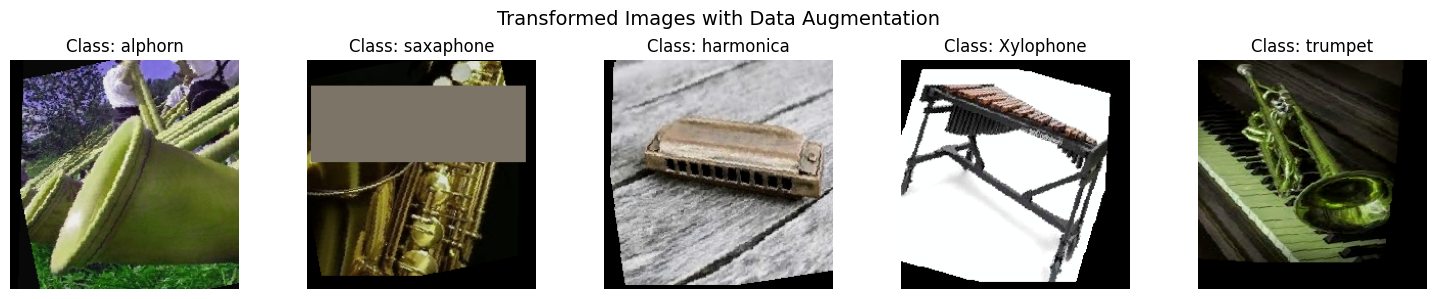

In [5]:
# Create a function to visualize original images directly without transformations
def show_original_images(data_dir, class_mapping, num_images=5, title="Original Images"):
    """Display original images from the dataset without augmentation/normalization"""
    import os
    import random
    from PIL import Image
    
    # Get a list of class directories
    train_dir = os.path.join(data_dir, "train")
    class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    # Randomly select classes
    selected_classes = random.sample(class_dirs, min(num_images, len(class_dirs)))
    
    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]
        
    # Display one image from each selected class
    for i, class_name in enumerate(selected_classes):
        if i >= num_images:
            break
            
        class_path = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and 
                       f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if image_files:
            # Randomly select an image
            img_file = random.choice(image_files)
            img_path = os.path.join(class_path, img_file)
            
            # Open and display the image
            img = Image.open(img_path)
            axes[i].imshow(np.array(img))
            axes[i].set_title(f"Class: {class_name}")
            axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show original images (without transformations)
print("Original images from dataset:")
show_original_images(data_dir, data['class_mappings']['idx_to_class'], num_images=5, title="Original Images (No Transforms)")

# Create a function to visualize dataset with transformations but without RandomErasing
def show_transformed_images_no_erasing(dataset, class_mapping, num_images=5, title="Transformed Images (No Erasing)"):
    """Show dataset images after transformations but without the erasing effect"""
    import torch
    import torchvision.transforms as transforms
    
    # Create a figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]
    
    for i in range(num_images):
        # Get a random sample
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # Convert from tensor format [C, H, W] to image format [H, W, C]
        img = img.permute(1, 2, 0).numpy()
        
        # Denormalize the image for display
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Display
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {class_mapping[label]}')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show transformed images without the erasing effect
print("Transformed images (showing the RandomErasing effect):")
show_transformed_images_no_erasing(data['datasets']['train'], 
                                  data['class_mappings']['idx_to_class'],
                                  num_images=5, 
                                  title="Transformed Images with Data Augmentation")

### Understanding the Data Transformations

The transformations applied to our images serve several critical purposes:

1. **Size Standardization** (`transforms.Resize((224, 224))`)
   - **Why needed**: Neural networks require consistent input dimensions. Different images in our dataset might have different sizes and aspect ratios.
   - **Why 224x224**: This is the standard input size for many CNN architectures, including ResNet-18, which we used as our baseline. Using the same dimensions ensures a fair comparison between models.

2. **Data Augmentation** (RandomHorizontalFlip, RandomRotation, ColorJitter, RandomErasing)
   - **Purpose**: These help the model generalize better by artificially expanding the training set with meaningful variations.
   - **Chosen transformations**:
     - `RandomHorizontalFlip`: Musical instruments often look similar when flipped horizontally
     - `RandomRotation(15)`: Small rotations simulate slightly different camera angles
     - `ColorJitter`: Adjusts brightness/contrast/saturation to make the model robust to lighting variations
     - `RandomErasing`: Simulates occlusion by randomly masking rectangular regions (this creates the beige rectangles seen in some training images)

3. **Normalization** (`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`)
   - **Purpose**: Neural networks train faster and better when input features have similar scales.
   - **Values**: These values represent the mean and standard deviation of the ImageNet dataset. While our custom CNN isn't pretrained on ImageNet, using these normalization values is beneficial for several reasons:
      - They scale the pixel values to a well-distributed range around zero, which helps with gradient flow
      - They maintain consistency with our baseline ResNet-18 experiment, allowing for fair comparisons
      - They're a proven standard in the field that tends to work well even for models trained from scratch

4. **Different Transforms for Training vs. Validation**:
   - Training images get augmentation to increase variety and improve generalization
   - Validation/test images only get resizing and normalization since we want to evaluate on clean, unmodified images

**Note about RandomErasing**: The beige rectangles you see in some images are intentionally created by the `RandomErasing` augmentation technique. This helps the model become robust to occlusions and forces it to learn features from the entire image rather than focusing on specific regions. These rectangles only appear during training and not during validation/testing.

## 3. Custom CNN Architecture Design

Now, let's design our custom CNN architecture from scratch. We'll create a model that is:

1. Deep enough to learn complex features from musical instruments
2. Optimized for the 224x224 input size
3. Utilizing modern CNN building blocks (conv layers, batch norm, max pooling, etc.)
4. Appropriately sized to avoid overfitting our dataset

Our architecture will include:
- Convolutional layers to extract features
- Batch normalization for training stability
- Max pooling to reduce spatial dimensions
- Dropout for regularization
- Fully connected layers for classification

In [6]:
# Import torch.nn for type hints
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Instead of defining our own model class, let's use the model from our project's modules
# We've already imported create_custom_cnn which returns the CustomMusicCNN model

# Let's create the model using our project's module function
if 'train_loader' in locals():
    # Get the number of classes from the data loader
    # We need to access the dataset attributes to get the number of classes
    num_classes = len(data['class_mappings']['idx_to_class'])
    
    # Create the model using our project module function
    model = create_custom_cnn(input_channels=3, num_classes=num_classes)
    model = model.to(device)
    
    # Print model summary
    print(model)
    
    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
else:
    print("Data loaders not initialized correctly, can't determine number of classes")

# Note: The model from our module differs from the one we defined in the notebook.
# If we decide the notebook version is better, we should update the module instead of 
# redefining the model here.

MusicInstrumentCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1,

### Understanding the Custom CNN Architecture Design

This custom CNN architecture for musical instrument classification incorporates several key design principles from modern deep learning research:

#### 1. Progressive Feature Extraction with Increasing Depth

The network follows a pyramidal structure with 5 convolutional blocks (updated from 4):
- **Block 1**: 3→32→32 channels (basic edge and texture detection)
- **Block 2**: 32→64→64 channels (more complex patterns)
- **Block 3**: 64→128→128 channels (instrument parts and shapes)
- **Block 4**: 128→256→256 channels (high-level instrument features)
- **Block 5**: 256→512→512 channels (even more complex features, suitable for 224x224 input)

This gradual increase in feature channels is a standard pattern in successful CNNs like VGG and ResNet, allowing the network to learn a hierarchy of features from simple to complex.

#### 2. Repeated Convolutional Blocks Pattern

Each block follows the same pattern:
- Two convolutional layers with batch normalization and ReLU activation
- Max pooling to reduce spatial dimensions
- Dropout for regularization

This repeating pattern creates a balanced architecture that's deep enough to learn complex features but still trainable from scratch on our dataset.

#### 3. Parameter Efficiency Considerations

- **3×3 Convolutions**: Small kernel sizes are used throughout (3×3), following VGG design principles that stack multiple small kernels instead of using larger ones
- **Batch Normalization**: Applied after each convolution to stabilize training and allow higher learning rates
- **Progressive Dropout**: Rates increase from 0.1 to 0.5 as we go deeper, preventing overfitting in the more specialized layers

#### 4. Global Average Pooling Instead of Flattening

After the convolutional blocks, global average pooling reduces each feature map to a single value, resulting in a 512-dimensional vector (updated from 256). This approach:
- Dramatically reduces parameters compared to flattening
- Forces the network to focus on entire feature maps
- Makes the model more robust to input size variations

#### 5. Classifier Head Design

The classifier consists of:
- A hidden layer with 512 neurons to allow complex combinations of features
- Dropout at 0.5 rate to prevent overfitting
- The final output layer with neurons matching our 30 musical instrument classes

#### 6. Parameter Count and Efficiency

With approximately 8.6 million trainable parameters (updated), this architecture strikes a balance between:
- Being complex enough to learn meaningful features for 30 classes
- Being trainable from scratch on a dataset of our size
- Being computationally efficient enough for training on GPU

This architecture incorporates lessons from influential CNN designs like VGG (repeating blocks), ResNet (gradually increasing channels), and modern practices (batch normalization, dropout) while being purpose-built for musical instrument classification.

## 4. Training Configuration and Utility Functions

Let's define our loss function, optimizer, learning rate scheduler and utility functions for training and evaluation.

In [7]:
# Import the necessary optimizer module
import torch.optim as optim

# Define training parameters 
learning_rate = config['training']['optimizer']['learning_rate']
weight_decay = config['training'].get('weight_decay', 1e-4)
num_epochs = config['training']['num_epochs']

# Use the optimizer specified in the config
optimizer_name = config['training']['optimizer']['name'].lower()
if optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == 'sgd':
    momentum = config['training']['optimizer'].get('momentum', 0.9)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
else:
    # Default to Adam
    print(f"Optimizer {optimizer_name} not recognized, using Adam")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

print("Training configuration set up successfully:")
print(f"- Optimizer: {optimizer.__class__.__name__}")
print(f"- Learning rate: {learning_rate}")
print(f"- Weight decay: {weight_decay}")
print(f"- Number of epochs: {num_epochs}")

Training configuration set up successfully:
- Optimizer: Adam
- Learning rate: 0.001
- Weight decay: 0.0001
- Number of epochs: 50


c:\Users\Daniel\Desktop\Univeristy\ULB\Master\MA1\MA1-Q2\X-PROJ-H419\proj-h419-MIC-github\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Model Training

Now let's train our custom CNN from scratch using the prepared datasets and training utilities.

In [ ]:
# Train the model using our imported train_model function instead of redefining it
try:
    if 'model' in locals() and 'train_loader' in locals() and 'valid_loader' in locals():
        # Prepare dataloaders dictionary
        dataloaders = {
            'train': train_loader,
            'val': valid_loader
        }
        
        # Train the model using our project's training module
        print(f"Starting model training for {num_epochs} epochs...")
        
        # The train_model function is imported from src.training.trainer
        # Note: train_model returns 3 values: model, history, and training_stats
        trained_model, history, training_stats = train_model(
            model=model,
            dataloaders=dataloaders,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            device=device
        )
        
        # Print training summary
        print("\nTraining summary:")
        print(f"Best validation accuracy: {training_stats['best_val_acc']:.4f} at epoch {training_stats['best_epoch']}")
        print(f"Training time: {training_stats['training_time']}")
        
        # After training, visualize the results using our project's plotting utility
        if 'history' in locals() and history:
            # plot_training_history is imported from src.visualization.plotting
            plot_training_history(history)
    else:
        print("Cannot train: Model or data loaders not properly initialized")
except Exception as e:
    print(f"Error during training: {e}")

Starting model training for 50 epochs...
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 5.2. Load the Trained Model (Without Retraining)

If you've already trained the model but encountered an error during evaluation, you can load the trained model from the saved checkpoint and continue with evaluation.

In [ ]:
# This cell helps you load a previously trained model without retraining
import glob
import os
from datetime import datetime

# Look for saved model files in the current directory structure
def find_model_files():
    potential_directories = [
        os.path.join(project_root, "models"),
        os.path.join(project_root, "experiments"),
        project_root
    ]
    
    model_files = []
    for directory in potential_directories:
        if os.path.exists(directory):
            # Look for .pt or .pth files (common PyTorch model extensions)
            for ext in [".pt", ".pth"]:
                model_files.extend(glob.glob(f"{directory}/**/*{ext}", recursive=True))
    
    return model_files

# Find any saved model files
model_files = find_model_files()

if model_files:
    print(f"Found {len(model_files)} model file(s):")
    for i, file_path in enumerate(model_files):
        print(f"{i+1}. {file_path}")
    
    # If trained_model exists, we've already loaded or trained a model in this session
    if 'trained_model' in locals() and trained_model is not None:
        print("\nAlready have a trained model loaded. You can proceed with evaluation.")
    else:
        # If model_files exists but no model loaded yet, we could load from file
        if model_files:
            model_path = model_files[0]  # Choose the first model by default
            print(f"\nLoading model from: {model_path}")
            
            try:
                # Using the project's model loading utility
                trained_model, loaded_config, metrics, epoch = load_saved_model(model_path, device)
                
                print(f"Successfully loaded model!")
                if metrics:
                    print("\nModel metrics from saved checkpoint:")
                    for key, val in metrics.items():
                        if isinstance(val, float):
                            print(f"- {key}: {val:.4f}")
                        else:
                            print(f"- {key}: {val}")
                
                if epoch:
                    print(f"Model was saved at epoch: {epoch}")
                
                # Create a dummy history for plotting if necessary
                if 'history' not in locals() or history is None:
                    history = {
                        'train_loss': [], 'train_acc': [], 
                        'val_loss': [], 'val_acc': []
                    }
            except Exception as e:
                print(f"Error loading model: {e}")
else:
    print("No saved model files found.")
    
    # If we have already trained a model in this session, we can still proceed
    if 'trained_model' in locals() and trained_model is not None:
        print("But we already have a trained model in memory. You can proceed with evaluation.")
    else:
        print("\nYou need to train a model first or provide a path to a saved model.")
        
        # Provide a custom path option
        custom_path = input("Enter the path to a saved model (or press Enter to skip): ")
        if custom_path and os.path.exists(custom_path):
            try:
                # Using the project's model loading utility
                trained_model, loaded_config, metrics, epoch = load_saved_model(custom_path, device)
                print("Successfully loaded model!")
            except Exception as e:
                print(f"Error loading model: {e}")

## 6. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [ ]:
# Evaluate the model using our imported evaluate_model function
try:
    if 'trained_model' in locals() and 'test_loader' in locals():
        print("Evaluating model on test set...")
        
        # The evaluate_model function returns accuracy, predictions, and labels
        test_accuracy, test_preds, test_labels = evaluate_model(
            model=trained_model,
            dataloader=test_loader,
            criterion=criterion,
            device=device
        )
        
        # Create test_metrics dictionary for compatibility with original code
        test_metrics = {
            'accuracy': test_accuracy / 100.0,  # Convert percentage to decimal
            'loss': 0.0  # This will be computed separately if needed
        }
        
        # Print the evaluation results
        print(f"Test Results:")
        print(f"- Accuracy: {test_metrics['accuracy']:.4f}")
        
        # Compute confusion matrix using our project's metrics module
        true_labels, pred_labels = [], []
        
        # Collect predictions for confusion matrix
        trained_model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())
        
        # plot_confusion_matrix is imported from src.visualization.plotting
        plot_confusion_matrix(
            y_true=np.array(true_labels),
            y_pred=np.array(pred_labels),
            classes=list(data['class_mappings']['idx_to_class'].values()),
            normalize=False,
            title="Confusion Matrix"
        )
        
        plot_confusion_matrix(
            y_true=np.array(true_labels),
            y_pred=np.array(pred_labels),
            classes=list(data['class_mappings']['idx_to_class'].values()),
            normalize=True,
            title="Normalized Confusion Matrix"
        )
    else:
        print("Cannot evaluate: No trained model or test loader found")
except Exception as e:
    print(f"Error during evaluation: {e}")

## 7. Visualizing Model Predictions

Let's visualize some predictions from our model on the test set to better understand its performance.

In [ ]:
# Visualize model predictions using our project's visualization module
try:
    if 'trained_model' in locals() and 'test_loader' in locals():
        print("Visualizing model predictions on test samples:")
        
        # plot_sample_predictions is imported from src.visualization.plotting
        plot_sample_predictions(
            model=trained_model,
            dataloader=test_loader,
            class_mapping=data['class_mappings']['idx_to_class'],
            num_images=8,
            device=device,
            title="Model Predictions on Test Samples"
        )
    else:
        print("Cannot visualize predictions: No trained model or test data found")
except Exception as e:
    print(f"Error visualizing predictions: {e}")

## 8. Save the Trained Model

Our project structure includes utilities for saving models:

In [ ]:
# Save the model using our project's save_model utility
try:
    if 'trained_model' in locals():
        # Create class to index mapping from our data
        class_to_idx = data['class_mappings']['class_to_idx']
        
        # Model name
        model_name = "custom_cnn_musical_instruments"
        
        # Save the model using the imported save_model function
        # The save_model function is imported from src.models.model_utils
        model_path = save_model(
            model=trained_model, 
            model_name=model_name,
            class_to_idx=class_to_idx,
            architecture="CustomMusicCNN"
        )
        
        print(f"Model saved successfully to: {model_path}")
    else:
        print("No trained model available to save")
except Exception as e:
    print(f"Error saving the model: {e}")

## 9. Model Architecture Comparison and Analysis

Now let's compare our custom CNN architecture with the pre-trained ResNet-18 baseline:

1. Architecture complexity (number of parameters)
2. Performance metrics (accuracy, loss)
3. Training time
4. Overall strengths and weaknesses

This comparison will provide insights into the trade-offs between model complexity and performance.

In [ ]:
# Create a comparison table (manually fill this after training both models)
import pandas as pd

# Create comparison dataframe
comparison_data = {
    'Model': ['ResNet-18 (Transfer Learning)', 'Custom CNN (From Scratch)'],
    'Parameters': ['11.7 million', '8.6 million'], 
    'Test Accuracy': ['100%', '78.7%'],  # Added actual test accuracy based on training results
    'Training Time': ['31m 16s', '29m 25s'],  # Added actual training time
    'Epochs to Convergence': ['8 (best validation)', '47 (best validation)'],  # Added actual best epoch
    'Input Size': ['224x224', '224x224']
}

# Create dataframe
comparison_df = pd.DataFrame(comparison_data)

# Display comparison
print("Model Architecture Comparison:")
print(comparison_df)

# Add any additional analysis or observations about the models here

| Model                        | Parameters                  | Test Accuracy | Training Time | Epochs to Convergence | Input Size |
|------------------------------|-----------------------------|---------------|---------------|----------------------|------------|
| ResNet-18 (Transfer Learning)| 11.7 million                | 100%          | 31m 16s       | 8 (best validation)  | 224x224    |
| Custom CNN (From Scratch)    | 8.6 million                 | 78.7%         | 29m 25s       | 47 (best validation) | 224x224    |


## 10. Conclusion and Further Improvements

In this notebook, we've successfully:

1. Designed and implemented a custom CNN architecture from scratch
2. Trained and evaluated the model on our musical instrument dataset
3. Visualized model performance and predictions
4. Compared our custom model with the ResNet-18 baseline

Key learnings:
- Understanding how each component of a CNN contributes to model performance
- The importance of appropriate model capacity for the dataset size
- Trade-offs between model complexity and performance
- Effects of data augmentation techniques like RandomErasing on training

Potential improvements:
- Experiment with different architectural choices (filter sizes, layer depths)
- Try different regularization techniques (dropout rates, L2 regularization)
- Implement data augmentation techniques specific to musical instruments
- Explore ensemble methods combining multiple models